## Smart Home Temperature Control System

Traditional thermostats use simple on/off control, can be inefficient and uncomfortable. A fuzzy logic controller can provide efficient temperature control by considering these factors:

- How far the current temperature is from the desired temperature
- How quickly the temperature is changing
- How much heating or cooling power to apply

So if it's getting a bit cold, and it's cooling down fast, so let's turn up the heat moderately.

In [22]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

#### Fuzzy Variables
1. Temperature Error (input): Difference between desired and current temperature (-10°C to +10°C)
2. Temperature Change Rate (input): How fast temperature is changing (-5°C/min to +5°C/min)
3. HVAC Power (output): Heating/cooling power to apply (-100% to +100%, where negative is cooling, positive is heating)

In [23]:
# Input 1: Temperature error (desired - current)
# Negative means too hot, positive means too cold
temp_error = ctrl.Antecedent(np.arange(-10, 10.1, 0.1), 'temperature_error')

# Input 2: Rate of temperature change
# Negative means cooling down, positive means heating up
temp_rate = ctrl.Antecedent(np.arange(-5, 5.1, 0.1), 'temperature_rate')

# Output: HVAC power
# Negative values = cooling, positive values = heating
hvac_power = ctrl.Consequent(np.arange(-100, 101, 1), 'hvac_power')

#### Membership Functions

In [24]:
# Temperature error membership functions
temp_error['too_cold'] = fuzz.trapmf(temp_error.universe, [5, 7, 10, 10])
temp_error['cold'] = fuzz.trimf(temp_error.universe, [2, 5, 8])
temp_error['comfortable'] = fuzz.trimf(temp_error.universe, [-2, 0, 2])
temp_error['warm'] = fuzz.trimf(temp_error.universe, [-8, -5, -2])
temp_error['too_hot'] = fuzz.trapmf(temp_error.universe, [-10, -10, -7, -5])

# Temperature change rate membership functions
temp_rate['cooling_fast'] = fuzz.trapmf(temp_rate.universe, [-5, -5, -3, -1])
temp_rate['cooling'] = fuzz.trimf(temp_rate.universe, [-2, -1, 0])
temp_rate['stable'] = fuzz.trimf(temp_rate.universe, [-0.5, 0, 0.5])
temp_rate['heating'] = fuzz.trimf(temp_rate.universe, [0, 1, 2])
temp_rate['heating_fast'] = fuzz.trapmf(temp_rate.universe, [1, 3, 5, 5])

# HVAC power membership functions
hvac_power['cool_high'] = fuzz.trapmf(hvac_power.universe, [-100, -100, -80, -50])
hvac_power['cool_medium'] = fuzz.trimf(hvac_power.universe, [-70, -40, -10])
hvac_power['cool_low'] = fuzz.trimf(hvac_power.universe, [-30, -15, 0])
hvac_power['off'] = fuzz.trimf(hvac_power.universe, [-10, 0, 10])
hvac_power['heat_low'] = fuzz.trimf(hvac_power.universe, [0, 15, 30])
hvac_power['heat_medium'] = fuzz.trimf(hvac_power.universe, [10, 40, 70])
hvac_power['heat_high'] = fuzz.trapmf(hvac_power.universe, [50, 80, 100, 100])

/Users/kiansahafi/Desktop/Classes/fuzzy systems class/fuzzy-tutorial/venv/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


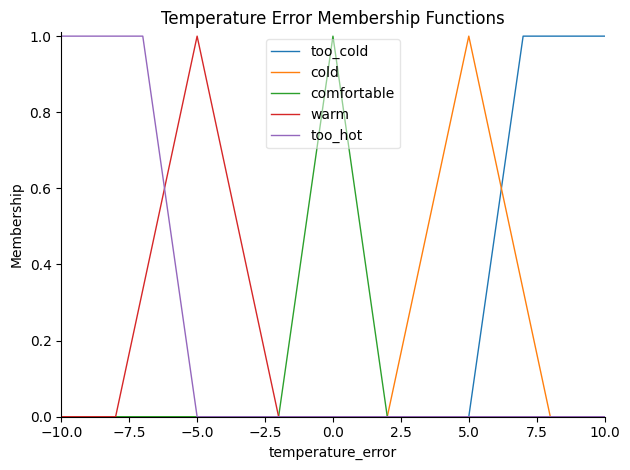

In [25]:
# temperature error
temp_error.view()
plt.title('Temperature Error Membership Functions')
plt.tight_layout()

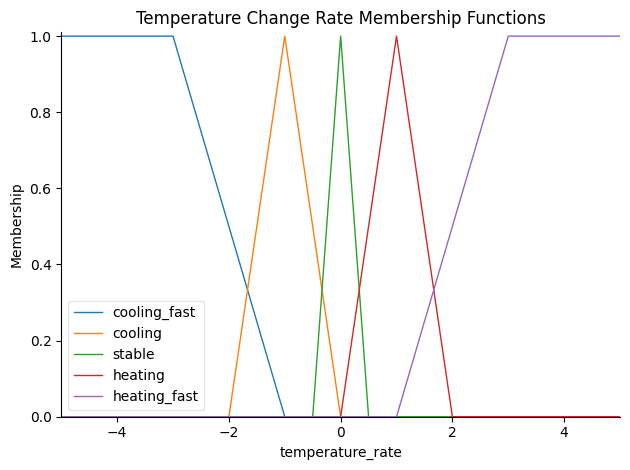

In [26]:
# temperature rate
temp_rate.view()
plt.title('Temperature Change Rate Membership Functions')
plt.tight_layout()

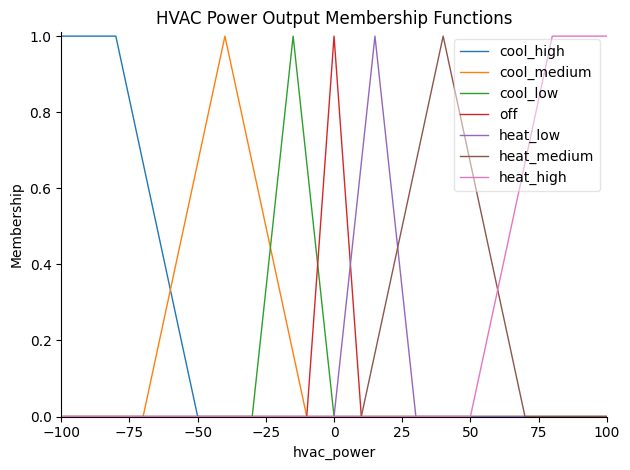

In [27]:
# HVAC power
hvac_power.view()
plt.title('HVAC Power Output Membership Functions')
plt.tight_layout()

#### Fuzzy Rules

- If it's too cold and cooling down → heat aggressively
- If it's comfortable and stable → turn off HVAC
- If it's hot and heating up → cool aggressively
- Moderate responses for intermediate situations

In [28]:
rules = []

# when it's too cold
rules.append(ctrl.Rule(temp_error['too_cold'] & temp_rate['cooling_fast'], hvac_power['heat_high']))
rules.append(ctrl.Rule(temp_error['too_cold'] & temp_rate['cooling'], hvac_power['heat_high']))
rules.append(ctrl.Rule(temp_error['too_cold'] & temp_rate['stable'], hvac_power['heat_medium']))
rules.append(ctrl.Rule(temp_error['too_cold'] & temp_rate['heating'], hvac_power['heat_medium']))
rules.append(ctrl.Rule(temp_error['too_cold'] & temp_rate['heating_fast'], hvac_power['heat_low']))

# when it's cold
rules.append(ctrl.Rule(temp_error['cold'] & temp_rate['cooling_fast'], hvac_power['heat_high']))
rules.append(ctrl.Rule(temp_error['cold'] & temp_rate['cooling'], hvac_power['heat_medium']))
rules.append(ctrl.Rule(temp_error['cold'] & temp_rate['stable'], hvac_power['heat_low']))
rules.append(ctrl.Rule(temp_error['cold'] & temp_rate['heating'], hvac_power['heat_low']))
rules.append(ctrl.Rule(temp_error['cold'] & temp_rate['heating_fast'], hvac_power['off']))

# comfortable temperature
rules.append(ctrl.Rule(temp_error['comfortable'] & temp_rate['cooling_fast'], hvac_power['heat_low']))
rules.append(ctrl.Rule(temp_error['comfortable'] & temp_rate['cooling'], hvac_power['off']))
rules.append(ctrl.Rule(temp_error['comfortable'] & temp_rate['stable'], hvac_power['off']))
rules.append(ctrl.Rule(temp_error['comfortable'] & temp_rate['heating'], hvac_power['off']))
rules.append(ctrl.Rule(temp_error['comfortable'] & temp_rate['heating_fast'], hvac_power['cool_low']))

# when it's warm
rules.append(ctrl.Rule(temp_error['warm'] & temp_rate['cooling_fast'], hvac_power['off']))
rules.append(ctrl.Rule(temp_error['warm'] & temp_rate['cooling'], hvac_power['cool_low']))
rules.append(ctrl.Rule(temp_error['warm'] & temp_rate['stable'], hvac_power['cool_low']))
rules.append(ctrl.Rule(temp_error['warm'] & temp_rate['heating'], hvac_power['cool_medium']))
rules.append(ctrl.Rule(temp_error['warm'] & temp_rate['heating_fast'], hvac_power['cool_high']))

# when it's too hot
rules.append(ctrl.Rule(temp_error['too_hot'] & temp_rate['cooling_fast'], hvac_power['cool_low']))
rules.append(ctrl.Rule(temp_error['too_hot'] & temp_rate['cooling'], hvac_power['cool_medium']))
rules.append(ctrl.Rule(temp_error['too_hot'] & temp_rate['stable'], hvac_power['cool_medium']))
rules.append(ctrl.Rule(temp_error['too_hot'] & temp_rate['heating'], hvac_power['cool_high']))
rules.append(ctrl.Rule(temp_error['too_hot'] & temp_rate['heating_fast'], hvac_power['cool_high']))

#### Creating and Testing the Control System

In [29]:
hvac_ctrl = ctrl.ControlSystem(rules)
hvac_sim = ctrl.ControlSystemSimulation(hvac_ctrl)

#### Test


=== Scenario 1: Too Cold & Cooling Fast ===
Desired temp: 22°C, Current temp: 16°C
Temperature change rate: -2°C/min (cooling)
→ HVAC Power: 78.5%
  (Positive = Heating, Negative = Cooling)


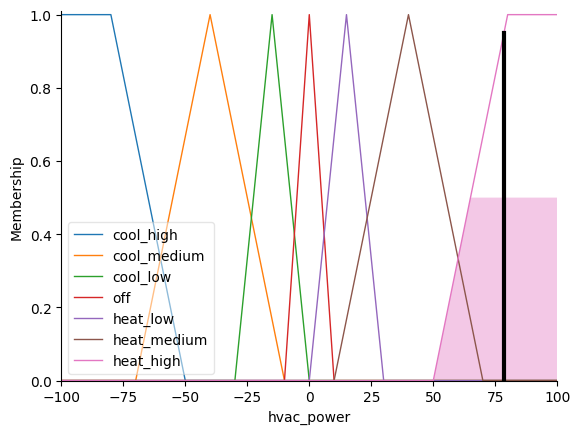

In [30]:
print("\n=== Scenario 1: Too Cold & Cooling Fast ===")
print("Desired temp: 22°C, Current temp: 16°C")
print("Temperature change rate: -2°C/min (cooling)")

hvac_sim.input['temperature_error'] = 6  # 22 - 16 = 6
hvac_sim.input['temperature_rate'] = -2  # cooling
hvac_sim.compute()

print(f"→ HVAC Power: {hvac_sim.output['hvac_power']:.1f}%")
print("  (Positive = Heating, Negative = Cooling)")
hvac_power.view(sim=hvac_sim)


=== Scenario 2: Comfortable & Stable ===
Desired temp: 22°C, Current temp: 22°C
Temperature change rate: 0°C/min (stable)
→ HVAC Power: 0.0%
  (Should be close to 0 = OFF)


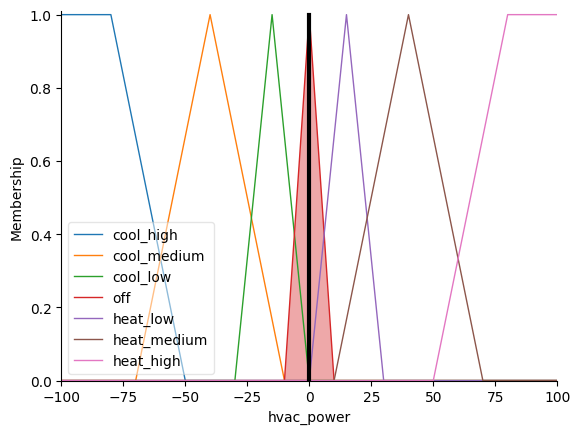

In [31]:
print("\n=== Scenario 2: Comfortable & Stable ===")
print("Desired temp: 22°C, Current temp: 22°C")
print("Temperature change rate: 0°C/min (stable)")

hvac_sim.input['temperature_error'] = 0  # 22 - 22 = 0
hvac_sim.input['temperature_rate'] = 0  # stable
hvac_sim.compute()

print(f"→ HVAC Power: {hvac_sim.output['hvac_power']:.1f}%")
print("  (Should be close to 0 = OFF)")
hvac_power.view(sim=hvac_sim)


=== Scenario 3: Too Hot & Heating Up ===
Desired temp: 22°C, Current temp: 28°C
Temperature change rate: +1.5°C/min (heating up)
→ HVAC Power: -58.6%
  (Negative = Cooling needed)


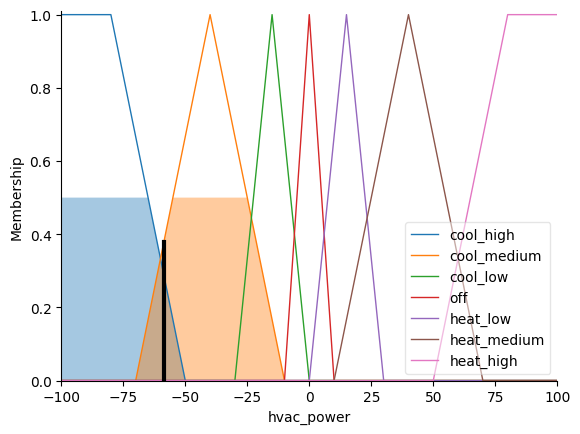

In [32]:
print("\n=== Scenario 3: Too Hot & Heating Up ===")
print("Desired temp: 22°C, Current temp: 28°C")
print("Temperature change rate: +1.5°C/min (heating up)")

hvac_sim.input['temperature_error'] = -6  # 22 - 28 = -6
hvac_sim.input['temperature_rate'] = 1.5  # heating up
hvac_sim.compute()

print(f"→ HVAC Power: {hvac_sim.output['hvac_power']:.1f}%")
print("  (Negative = Cooling needed)")
hvac_power.view(sim=hvac_sim)


=== Scenario 4: Slightly Cold but Warming Up ===
Desired temp: 22°C, Current temp: 20°C
Temperature change rate: +0.8°C/min (warming up)
→ HVAC Power: 8.0%
  (Low heating since it's already warming up)


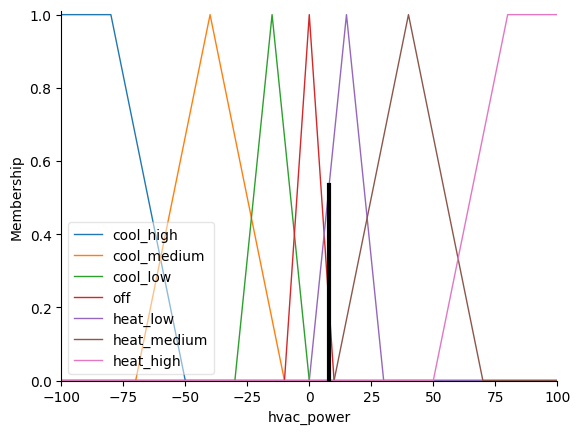

In [33]:
# Scenario 4: Slightly cold but warming up
# Desired: 22°C, Current: 20°C, Rate: +0.8°C/min
print("\n=== Scenario 4: Slightly Cold but Warming Up ===")
print("Desired temp: 22°C, Current temp: 20°C")
print("Temperature change rate: +0.8°C/min (warming up)")

hvac_sim.input['temperature_error'] = 2  # 22 - 20 = 2
hvac_sim.input['temperature_rate'] = 0.8  # warming up
hvac_sim.compute()

print(f"→ HVAC Power: {hvac_sim.output['hvac_power']:.1f}%")
print("  (Low heating since it's already warming up)")
hvac_power.view(sim=hvac_sim)

#### System Response Surface

visualization of how the system responds to different combinations of temperature error and rate of change:

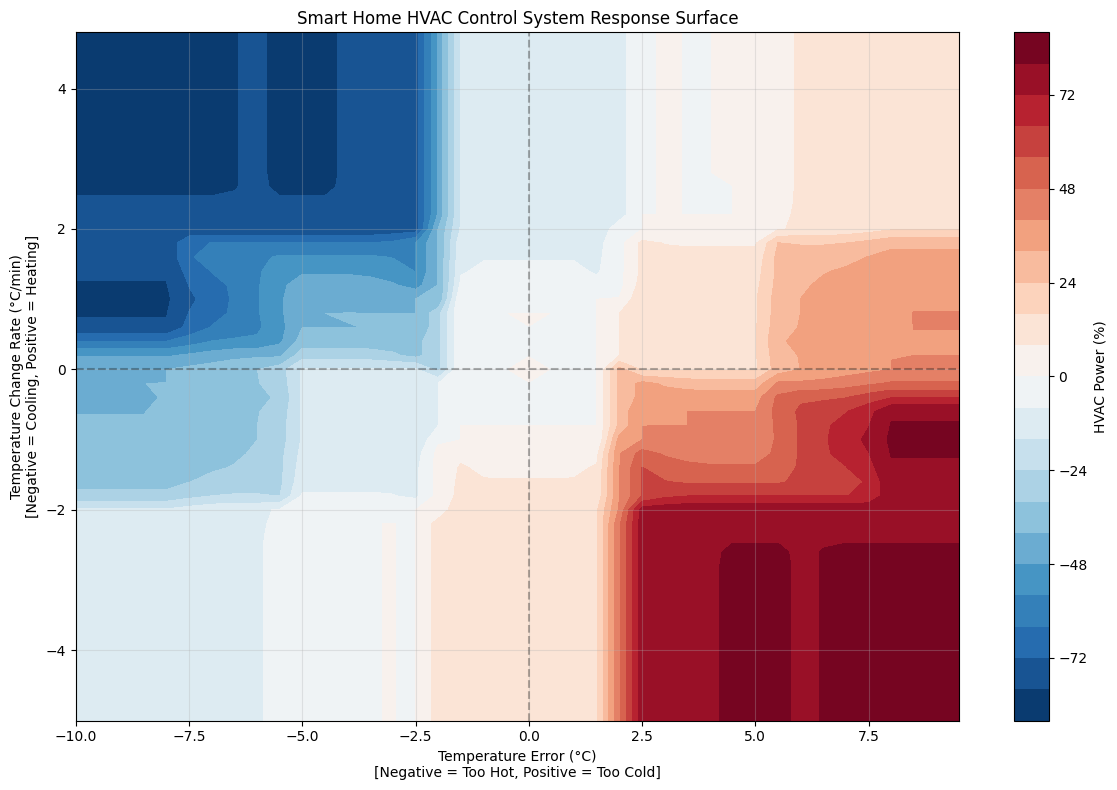

In [34]:
temp_error_range = np.arange(-10, 10, 0.5)
temp_rate_range = np.arange(-5, 5, 0.2)

output_grid = np.zeros((len(temp_rate_range), len(temp_error_range)))

for i, rate in enumerate(temp_rate_range):
    for j, error in enumerate(temp_error_range):
        hvac_sim.input['temperature_error'] = error
        hvac_sim.input['temperature_rate'] = rate
        hvac_sim.compute()
        output_grid[i, j] = hvac_sim.output['hvac_power']

plt.figure(figsize=(12, 8))
plt.contourf(temp_error_range, temp_rate_range, output_grid, levels=20, cmap='RdBu_r')
plt.colorbar(label='HVAC Power (%)')
plt.xlabel('Temperature Error (°C)\n[Negative = Too Hot, Positive = Too Cold]')
plt.ylabel('Temperature Change Rate (°C/min)\n[Negative = Cooling, Positive = Heating]')
plt.title('Smart Home HVAC Control System Response Surface')
plt.grid(True, alpha=0.3)


plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

- The response surface shows how the system smoothly adjusts power 
- based on both temperature error and rate of change.
- Red areas = heating needed, Blue areas = cooling needed

## Comparison: Fuzzy vs. Traditional Control

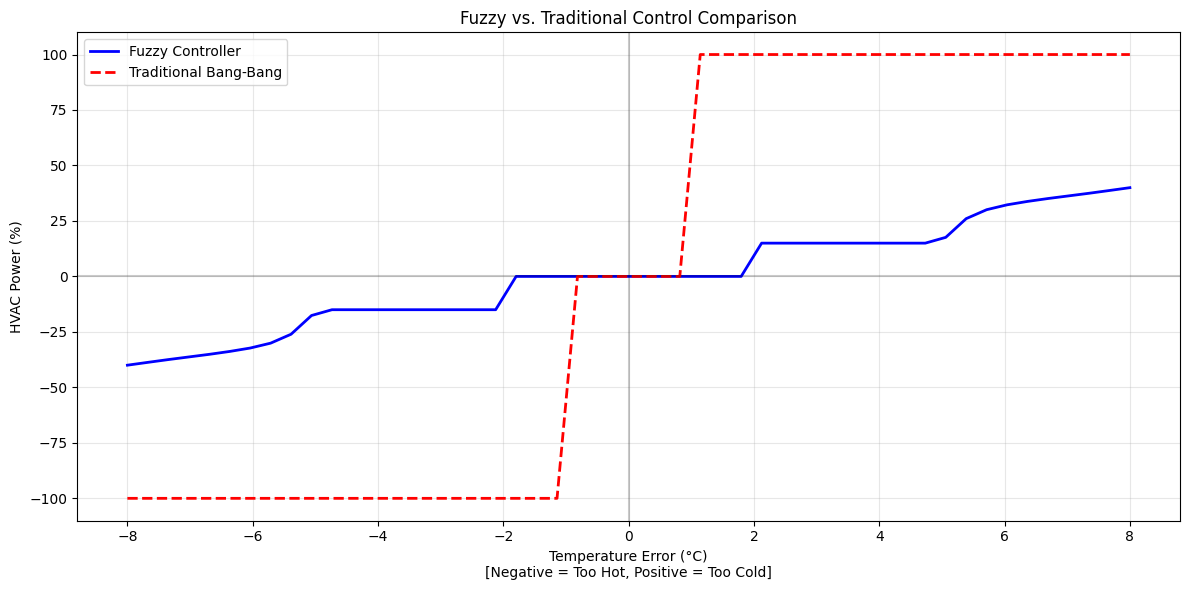

In [35]:
def traditional_controller(error):
    """Traditional on/off controller"""
    if error > 1:
        return 100  # Full heating
    elif error < -1:
        return -100  # Full cooling
    else:
        return 0  # Off

# Test both controllers with varying temperature error
errors = np.linspace(-8, 8, 50)
rate = 0  # Assume stable rate for this comparison

fuzzy_outputs = []
bangbang_outputs = []

for error in errors:
    hvac_sim.input['temperature_error'] = error
    hvac_sim.input['temperature_rate'] = rate
    hvac_sim.compute()
    fuzzy_outputs.append(hvac_sim.output['hvac_power'])
    
    bangbang_outputs.append(traditional_controller(error))

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(errors, fuzzy_outputs, 'b-', linewidth=2, label='Fuzzy Controller')
plt.plot(errors, bangbang_outputs, 'r--', linewidth=2, label='Traditional Bang-Bang')
plt.xlabel('Temperature Error (°C)\n[Negative = Too Hot, Positive = Too Cold]')
plt.ylabel('HVAC Power (%)')
plt.title('Fuzzy vs. Traditional Control Comparison')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.2)
plt.tight_layout()
plt.show()
